In [203]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import os
import tushare as ts
from datetime import datetime
import yfinance as yf
 
import warnings

warnings.filterwarnings("ignore")

In [204]:
# ts.set_token('c39e3c5b040f85d3f794284d5c0626fb08581b8b965ae67208563727')

# pro = ts.pro_api()

# # Get stock data (example: get daily stock data for SZSE 002230)
# stock_data = pro.daily(ts_code='002230.SZ', start_date='20220101', end_date='20221231')

# print(stock_data)

# stock_data['trade_date'] = pd.to_datetime(stock_data['trade_date'])

stock_data = yf.download('U', start='2020-01-01')

stock_data['date'] = stock_data.index
stock_data['date'] = pd.to_datetime(stock_data['date'])

# apple['date'] = apple.index
# apple['date'] = pd.to_datetime(apple['date'])
# apple.info

[*********************100%%**********************]  1 of 1 completed


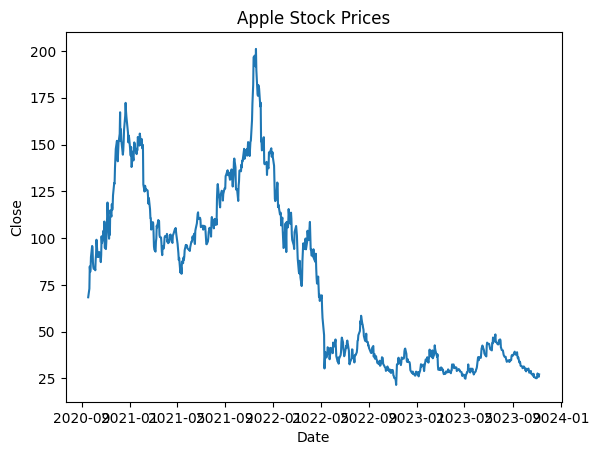

In [205]:
plt.plot(stock_data['date'],stock_data['Close'])
plt.xlabel("Date")
plt.ylabel("Close")
plt.title("Apple Stock Prices")
plt.show()

In [206]:
close_data = stock_data.filter(['Close'])
dataset = close_data.values
training = int(np.ceil(len(dataset) * .5))
print(dataset)
print(training)

[[ 68.34999847]
 [ 72.95999908]
 [ 84.81999969]
 [ 81.84999847]
 [ 83.19999695]
 [ 89.84999847]
 [ 95.80000305]
 [ 94.91999817]
 [ 87.27999878]
 [ 84.55999756]
 [ 83.52999878]
 [ 84.        ]
 [ 82.79000092]
 [ 88.65000153]
 [ 91.40000153]
 [ 99.11000061]
 [ 90.        ]
 [ 92.11000061]
 [ 90.01999664]
 [ 91.43000031]
 [ 92.55999756]
 [ 89.30000305]
 [ 87.15000153]
 [ 91.        ]
 [100.95999908]
 [ 97.27999878]
 [ 99.95999908]
 [104.        ]
 [ 99.76000214]
 [108.83999634]
 [ 94.87999725]
 [ 94.12999725]
 [ 98.06999969]
 [106.44999695]
 [110.76000214]
 [119.        ]
 [102.84999847]
 [ 99.66000366]
 [105.58000183]
 [101.73999786]
 [114.76999664]
 [111.51000214]
 [118.05000305]
 [115.01000214]
 [116.30999756]
 [122.80000305]
 [129.3999939 ]
 [129.03999329]
 [137.46000671]
 [147.61999512]
 [151.97999573]
 [147.22999573]
 [141.05000305]
 [145.66999817]
 [150.94000244]
 [155.71000671]
 [167.25      ]
 [152.        ]
 [158.17999268]
 [152.5       ]
 [146.72000122]
 [144.58000183]
 [146.69

In [207]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

train_data = scaled_data[0:int(training), :]
# prepare feature and labels
x_train = []
y_train = []

for i in range(60, len(train_data)):
	x_train.append(train_data[i-60:i, 0])
	y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


In [208]:
model = keras.models.Sequential()
model.add(keras.layers.LSTM(units=64,
							return_sequences=True,
							input_shape=(x_train.shape[1], 1)))
model.add(keras.layers.LSTM(units=64))
model.add(keras.layers.Dense(32))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1))
print(model.summary())


Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_36 (LSTM)              (None, 60, 64)            16896     
                                                                 
 lstm_37 (LSTM)              (None, 64)                33024     
                                                                 
 dense_36 (Dense)            (None, 32)                2080      
                                                                 
 dropout_18 (Dropout)        (None, 32)                0         
                                                                 
 dense_37 (Dense)            (None, 1)                 33        
                                                                 
Total params: 52033 (203.25 KB)
Trainable params: 52033 (203.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [209]:
model.compile(optimizer='adam',
			loss='mean_squared_error')
history = model.fit(x_train,
					y_train,
					epochs=10)


Epoch 1/10
11/11 [==============================] - 2s 22ms/step - loss: 0.0879
Epoch 2/10
11/11 [==============================] - 0s 22ms/step - loss: 0.0250
Epoch 3/10
11/11 [==============================] - 0s 22ms/step - loss: 0.0229
Epoch 4/10
11/11 [==============================] - 0s 21ms/step - loss: 0.0184
Epoch 5/10
11/11 [==============================] - 0s 21ms/step - loss: 0.0179
Epoch 6/10
11/11 [==============================] - 0s 22ms/step - loss: 0.0152
Epoch 7/10
11/11 [==============================] - 0s 22ms/step - loss: 0.0174
Epoch 8/10
11/11 [==============================] - 0s 21ms/step - loss: 0.0154
Epoch 9/10
11/11 [==============================] - 0s 23ms/step - loss: 0.0134
Epoch 10/10
11/11 [==============================] - 0s 23ms/step - loss: 0.0176


In [210]:
test_data = scaled_data[training - 60:, :]
x_test = []
y_test = dataset[training:, :]
for i in range(60, len(test_data)):
	x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# predict the testing data
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# evaluation metrics
mse = np.mean(((predictions - y_test) ** 2))
print("MSE", mse)
print("RMSE", np.sqrt(mse))


13/13 [==============================] - 0s 6ms/step
MSE 223.77142710505618
RMSE 14.958991513636745


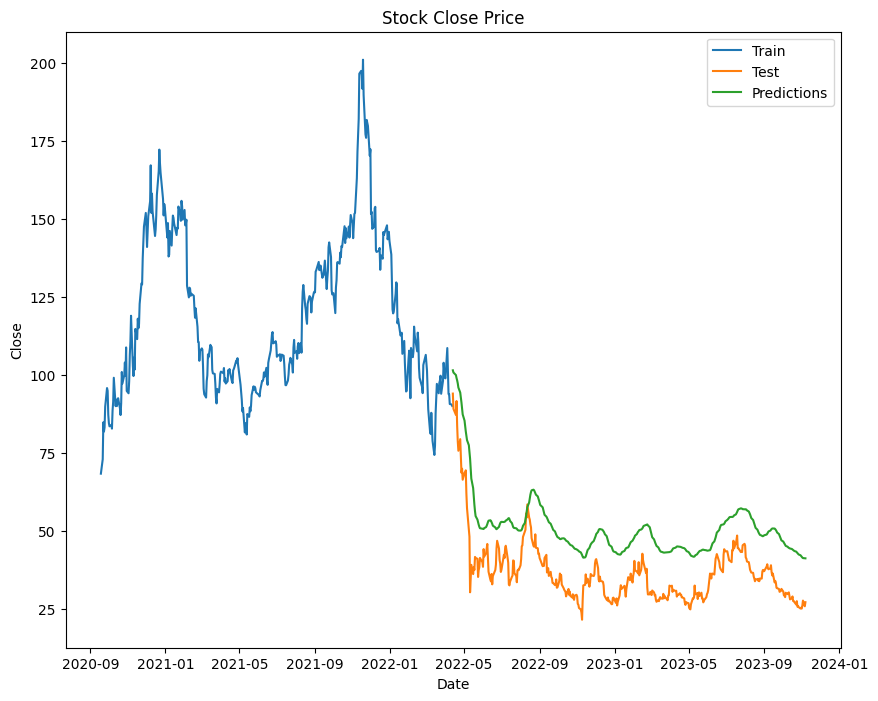

In [211]:
train = stock_data[:training]
test = stock_data[training:]
test['Predictions'] = predictions

plt.figure(figsize=(10, 8))
plt.plot(train['date'], train['Close'])
plt.plot(test['date'], test[['Close', 'Predictions']])
plt.title('Stock Close Price')
plt.xlabel('Date')
plt.ylabel("Close")
plt.legend(['Train', 'Test', 'Predictions'])
